
# 📙 Pipeline Gợi Ý Size — Bản mở rộng **kèm LOG chi tiết**

Bản này kế thừa notebook mở rộng (fit_preference + số đo cơ thể) và **tự động xuất log chi tiết**:
- `log_<model>.csv` cho từng model (toàn bộ `cv_results_` của GridSearchCV)
- `training_log.csv` tổng hợp model tốt nhất + điểm CV
- Ngoài ra vẫn lưu: `best_size_model_extended.joblib`, `model_meta_extended.json`, `garment_chart.csv`

> Chạy **tất cả các cell** để sinh dữ liệu, huấn luyện và xuất log.


In [1]:

# ======================
# 0) Import & cấu hình
# ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import joblib
import os
import json
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

OUTPUT_DIR = "../Recommend_size/save model"
os.makedirs(OUTPUT_DIR, exist_ok=True)



## A. Bảng số đo áo (garment chart)


In [2]:

garment_chart = pd.DataFrame({
    "Size":  ["XS","S","M","L","XL","XXL"],
    "Ngang_vai": [48,50,52,54,56,58],
    "Vong_nguc": [100,104,108,114,120,126],
    "Vong_eo":   [100,104,108,114,120,126],
    "Dai_tay_ngan": [21,22,23,24,25,26],
    "Dai_ao": [70,72,72,73,74,75]
})
garment_chart


,Size,Ngang_vai,Vong_nguc,Vong_eo,Dai_tay_ngan,Dai_ao
0,XS,48,100,100,21,70
1,S,50,104,104,22,72
2,M,52,108,108,23,72
3,L,54,114,114,24,73
4,XL,56,120,120,25,74
5,XXL,58,126,126,26,75



## B. Tạo dữ liệu **synthetic** (gồm fit_preference + số đo cơ thể)


In [3]:

ranges_female = {
    "XS":  {"h": (148, 158), "w": (40, 48)},
    "S":   {"h": (155, 165), "w": (48, 58)},
    "M":   {"h": (160, 170), "w": (58, 68)},
    "L":   {"h": (165, 175), "w": (68, 78)},
    "XL":  {"h": (170, 180), "w": (78, 90)},
    "XXL": {"h": (175, 195), "w": (90, 110)},
}

ranges_male = {
    "XS":  {"h": (155, 162), "w": (45, 52)},
    "S":   {"h": (160, 170), "w": (53, 62)},
    "M":   {"h": (165, 175), "w": (63, 75)},
    "L":   {"h": (170, 180), "w": (76, 88)},
    "XL":  {"h": (175, 190), "w": (89, 100)},
    "XXL": {"h": (180, 200), "w": (100, 130)},
}

garment_map = garment_chart.set_index("Size").to_dict(orient="index")

def sample_fit_preference(n):
    # 0: ôm, 1: vừa, 2: rộng
    return np.random.choice([0,1,2], size=n, p=[0.25, 0.5, 0.25])

def synthesize_group(gender_label, ranges, n_per_size=300, jitter=True):
    rows = []
    for size, cfg in ranges.items():
        h_low, h_high = cfg["h"]
        w_low, w_high = cfg["w"]
        n = n_per_size

        h = np.random.uniform(h_low, h_high, n)
        w = np.random.uniform(w_low, w_high, n)
        if jitter:
            h = h + np.random.normal(0, 1.2, n)
            w = w + np.random.normal(0, 1.0, n)

        fit_pref = sample_fit_preference(n)

        g = garment_map[size]
        ease_chest = np.random.uniform(6, 10, n)
        ease_waist = np.random.uniform(6, 10, n)
        ease_shoulder = np.random.uniform(1.0, 2.0, n)

        chest = g["Vong_nguc"] - ease_chest + np.random.normal(0, 0.8, n)
        waist = g["Vong_eo"]   - ease_waist + np.random.normal(0, 0.8, n)
        shoulder = g["Ngang_vai"] - ease_shoulder + np.random.normal(0, 0.4, n)

        for i in range(n):
            rows.append({
                "gender": gender_label,
                "height_cm": round(float(h[i]), 1),
                "weight_kg": round(float(w[i]), 1),
                "fit_preference": int(fit_pref[i]),
                "shoulder_cm": round(float(shoulder[i]), 1),
                "chest_cm": round(float(chest[i]), 1),
                "waist_cm": round(float(waist[i]), 1),
                "size": size
            })
    return pd.DataFrame(rows)

df_f = synthesize_group("Nữ", ranges_female, n_per_size=300, jitter=True)
df_m = synthesize_group("Nam", ranges_male, n_per_size=300, jitter=True)
df = pd.concat([df_f, df_m], axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Kích thước dataset:", df.shape)
df.head()


Kích thước dataset: (3600, 8)


,gender,height_cm,weight_kg,fit_preference,shoulder_cm,chest_cm,waist_cm,size
0,Nữ,173.3,87.2,1,54.2,111.9,114.0,XL
1,Nữ,186.8,92.2,0,57.0,118.2,118.5,XXL
2,Nam,181.2,110.7,2,56.1,119.0,119.1,XXL
3,Nam,193.3,125.2,1,57.0,118.1,117.5,XXL
4,Nữ,155.0,44.8,1,46.9,92.8,92.3,XS



## C. Xử lý dữ liệu (encode/split)


In [4]:

gender_map = {"Nữ": 0, "Nam": 1}
df["gender_code"] = df["gender"].map(gender_map).astype(int)

le_size = LabelEncoder()
df["size_label"] = le_size.fit_transform(df["size"])

feature_cols = ["gender_code","height_cm","weight_kg","fit_preference"]
X = df[feature_cols].values
y = df["size_label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

len(X_train), len(X_test), feature_cols


(2880, 720, ['gender_code', 'height_cm', 'weight_kg', 'fit_preference'])


## D. Huấn luyện nhiều model + **Ghi log chi tiết**
- Lưu `grid.cv_results_` từng model → `/mnt/data/log_<model>.csv`
- Lưu tổng hợp kết quả tốt nhất → `/mnt/data/training_log.csv`


c:\Users\chuon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


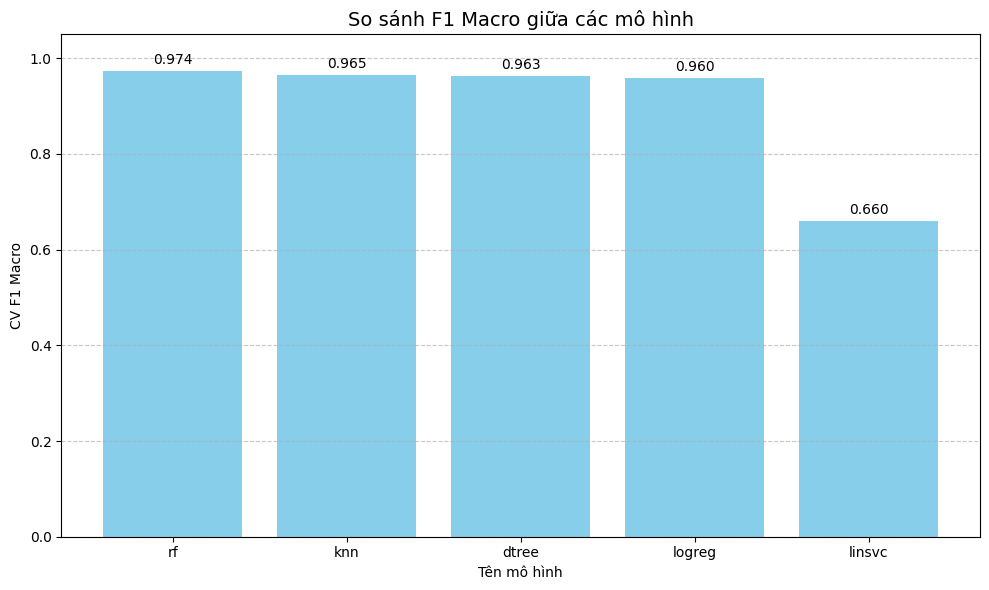

(    model                                        best_params  cv_f1_macro  \
 0      rf  {'clf__max_depth': None, 'clf__n_estimators': ...     0.974274   
 1     knn  {'clf__n_neighbors': 5, 'clf__weights': 'unifo...     0.964565   
 2   dtree  {'clf__max_depth': 10, 'clf__min_samples_split...     0.963155   
 3  logreg                                    {'clf__C': 2.0}     0.959705   
 4  linsvc                                    {'clf__C': 2.0}     0.659785   
 
                                       log_file  
 0      ../Recommend_size/save model\log_rf.csv  
 1     ../Recommend_size/save model\log_knn.csv  
 2   ../Recommend_size/save model\log_dtree.csv  
 3  ../Recommend_size/save model\log_logreg.csv  
 4  ../Recommend_size/save model\log_linsvc.csv  ,
 '../Recommend_size/save model\\training_log.csv')

In [5]:

models = {
    "logreg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", max_iter=300, random_state=SEED))
    ]),
    "knn": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier())
    ]),
    "dtree": Pipeline([
        ("clf", DecisionTreeClassifier(random_state=SEED))
    ]),
    "rf": Pipeline([
        ("clf", RandomForestClassifier(random_state=SEED))
    ]),
    "linsvc": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(random_state=SEED, dual="auto", max_iter=6000))
    ]),
}

param_grids = {
    "logreg": {"clf__C": [0.5, 1.0, 2.0]},
    "knn": {"clf__n_neighbors": [5, 9, 13], "clf__weights": ["uniform", "distance"]},
    "dtree": {"clf__max_depth": [None, 6, 10], "clf__min_samples_split": [2, 5]},
    "rf": {"clf__n_estimators": [150, 250], "clf__max_depth": [None, 8, 12]},
    "linsvc": {"clf__C": [0.5, 1.0, 2.0]}
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

results = []
best_estimators = {}

for name, pipe in models.items():
    grid = GridSearchCV(
        pipe, param_grids[name],
        scoring="f1_macro", cv=cv, n_jobs=-1, verbose=0, return_train_score=True
    )
    grid.fit(X_train, y_train)

    # ===> Ghi LOG chi tiết cho model này
    log_file = os.path.join(OUTPUT_DIR, f"log_{name}.csv")
    pd.DataFrame(grid.cv_results_).to_csv(log_file, index=False)

    best_estimators[name] = grid.best_estimator_
    results.append({
        "model": name,
        "best_params": grid.best_params_,
        "cv_f1_macro": grid.best_score_,
        "log_file": log_file
    })

results_df = pd.DataFrame(results).sort_values(by="cv_f1_macro", ascending=False).reset_index(drop=True)
# Vẽ biểu đồ so sánh F1 macro giữa các mô hình
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df["model"], results_df["cv_f1_macro"], color='skyblue')

# Hiển thị giá trị F1 trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10)

plt.title("So sánh F1 Macro giữa các mô hình", fontsize=14)
plt.ylabel("CV F1 Macro")
plt.xlabel("Tên mô hình")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
# Lưu training_log tổng hợp
summary_log = os.path.join(OUTPUT_DIR, "training_log.csv")
results_df.to_csv(summary_log, index=False)

results_df, summary_log



## E. Đánh giá model tốt nhất (test set) + Confusion Matrix


Model tốt nhất (CV): rf
Tham số: {'clf__max_depth': None, 'clf__n_estimators': 250}
CV F1-macro: 0.9743
Log chi tiết: ../Recommend_size/save model\log_rf.csv

Hiệu năng trên Test:
Accuracy: 0.9708
F1-macro: 0.9708

Báo cáo phân loại:
              precision    recall  f1-score   support

           L       0.94      0.98      0.96       120
           M       0.98      0.98      0.98       120
           S       0.98      0.98      0.98       120
          XL       0.96      0.92      0.94       120
          XS       1.00      0.97      0.99       120
         XXL       0.97      0.98      0.98       120

    accuracy                           0.97       720
   macro avg       0.97      0.97      0.97       720
weighted avg       0.97      0.97      0.97       720



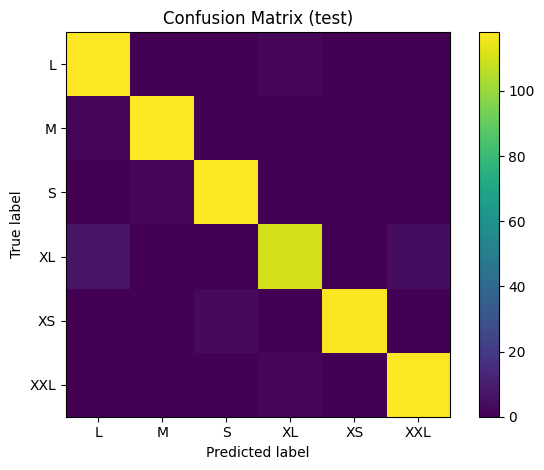

In [6]:

best_row = results_df.iloc[0]
best_name = best_row["model"]
best_model = best_estimators[best_name]

print("Model tốt nhất (CV):", best_name)
print("Tham số:", best_row["best_params"])
print("CV F1-macro:", round(best_row["cv_f1_macro"], 4))
print("Log chi tiết:", best_row["log_file"])

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print("\nHiệu năng trên Test:")
print("Accuracy:", round(acc, 4))
print("F1-macro:", round(f1m, 4))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=le_size.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (test)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(len(le_size.classes_)), le_size.classes_)
plt.yticks(range(len(le_size.classes_)), le_size.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()



## F. Hậu xử lý theo rule fit & Lưu model


In [7]:

# Rule dịch size theo fit
canonical_order = ["XS","S","M","L","XL","XXL"]
idx_map = {s:i for i,s in enumerate(canonical_order)}

def shift_size_by_fit(size_text, fit_pref):
    delta = -1 if fit_pref == 0 else (1 if fit_pref == 2 else 0)
    i = idx_map[size_text]
    j = min(max(i + delta, 0), len(canonical_order)-1)
    return canonical_order[j]

# Lưu
model_path = os.path.join(OUTPUT_DIR, "best_size_model_extended.joblib")
meta_path  = os.path.join(OUTPUT_DIR, "model_meta_extended.json")
garment_path = os.path.join(OUTPUT_DIR, "garment_chart.csv")

joblib.dump({
    "pipeline": best_model,
    "label_encoder_size": le_size,
    "gender_map": {"Nữ":0,"Nam":1},
    "feature_cols": ["gender_code","height_cm","weight_kg","fit_preference"],
    "canonical_order": canonical_order
}, model_path)

garment_chart.to_csv(garment_path, index=False)

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({
        "best_model_name": best_name,
        "cv_f1_macro": float(best_row["cv_f1_macro"]),
        "classes": list(le_size.classes_),
        "features": ["gender_code","height_cm","weight_kg","fit_preference"]
    }, f, ensure_ascii=False, indent=2)

model_path, meta_path, garment_path


('../Recommend_size/save model\\best_size_model_extended.joblib',
 '../Recommend_size/save model\\model_meta_extended.json',
 '../Recommend_size/save model\\garment_chart.csv')


## G. Demo suy luận (kết hợp fit rule)


In [8]:

bundle = joblib.load(os.path.join(OUTPUT_DIR, "best_size_model_extended.joblib"))
pipe = bundle["pipeline"]
le = bundle["label_encoder_size"]
gmap = bundle["gender_map"]
feature_cols = bundle["feature_cols"]
canonical_order = bundle["canonical_order"]

def predict_size_with_fit(gender_text, height_cm, weight_kg, fit_preference, apply_fit_rule=True):
    gender_code = gmap.get(gender_text, 0)
    X_new = np.array([[gender_code, height_cm, weight_kg, fit_preference]], dtype=float)
    y_pred = pipe.predict(X_new)[0]
    base_size = le.inverse_transform([y_pred])[0]
    final_size = shift_size_by_fit(base_size, fit_preference) if apply_fit_rule else base_size
    return base_size, final_size

# Ví dụ
sample = {
    "gender_text": "Nam",
    "height_cm": 165.0,
    "weight_kg": 55.0,
    "fit_preference": 1,   # ôm
}

base, final = predict_size_with_fit(**sample, apply_fit_rule=True)
print("Base size:", base, "| After fit rule:", final)


Base size: S | After fit rule: S
